In [1]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity
!pip install pytorch-fid
!pip install torchsummary

### Import Libraries

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from tqdm import tqdm
from torchsummary import summary
from torchvision.models import inception_v3
import torch.nn.functional as F
from scipy.linalg import sqrtm


### Preprocessing

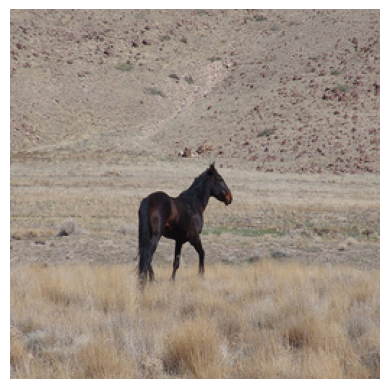

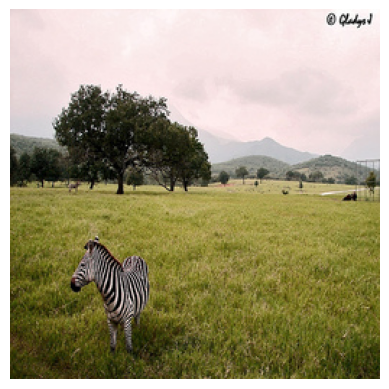

In [3]:
def read_image(file_path):
    return Image.open(file_path).convert('RGB')

def show_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

dataset_path = "/kaggle/input/image123"
horse_path = os.path.join(dataset_path, "trainA")
zebra_path = os.path.join(dataset_path, "trainB")

horse_images = [os.path.join(horse_path, img) for img in os.listdir(horse_path) if img.endswith('.jpg')]
zebra_images = [os.path.join(zebra_path, img) for img in os.listdir(zebra_path) if img.endswith('.jpg')]

show_image(read_image(horse_images[0]))
show_image(read_image(zebra_images[0]))

In [4]:
class Horse2ZebraDataset(Dataset):
    def __init__(self, horse_dir, zebra_dir, transform=None):
        self.horse_images = [os.path.join(horse_dir, img) for img in os.listdir(horse_dir) if img.endswith('.jpg')]
        self.zebra_images = [os.path.join(zebra_dir, img) for img in os.listdir(zebra_dir) if img.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return max(len(self.horse_images), len(self.zebra_images))

    def __getitem__(self, idx):
        horse_img_path = self.horse_images[idx % len(self.horse_images)]
        zebra_img_path = self.zebra_images[idx % len(self.zebra_images)]
        horse_img = read_image(horse_img_path)
        zebra_img = read_image(zebra_img_path)
        if self.transform:
            horse_img = self.transform(horse_img)
            zebra_img = self.transform(zebra_img)
        return horse_img, zebra_img

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = Horse2ZebraDataset(horse_path, zebra_path, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

real_data_loader = DataLoader(Subset(dataset, range(100)), batch_size=16, shuffle=True, num_workers=4)
generated_data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 256

In [6]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean = 0.
    std = 0.
    for horse_imgs, zebra_imgs in loader:
        imgs = torch.cat((horse_imgs, zebra_imgs), 0)
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
    mean /= len(loader.dataset) * 2
    std /= len(loader.dataset) * 2
    return mean, std

mean, std = calculate_mean_std(dataset)
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([ 0.0099, -0.0142, -0.1442]), Std: tensor([0.4350, 0.4309, 0.4404])


### Generator

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator model
class Generator(nn.Module):
    def __init__(self, img_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

### Discriminator

In [8]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### Deep Convolutional GAN

In [9]:
class GAN(nn.Module):
    def __init__(self, img_size):
        super(GAN, self).__init__()
        self.generator = Generator(img_size)
        self.discriminator = Discriminator(img_size)

        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)

    def forward(self, img_size):
        return self.generator(img_size)
    
gan = GAN(img_size).to(device)
summary(gan.generator, (3, img_size, img_size))
summary(gan.discriminator, (3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
              ReLU-5          [-1, 128, 64, 64]               0
   ConvTranspose2d-6         [-1, 64, 128, 128]         131,072
       BatchNorm2d-7         [-1, 64, 128, 128]             128
              ReLU-8         [-1, 64, 128, 128]               0
   ConvTranspose2d-9          [-1, 3, 256, 256]           3,072
             Tanh-10          [-1, 3, 256, 256]               0
Total params: 268,672
Trainable params: 268,672
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 55.00
Params size (MB): 1.02
Estimated 

### Train The Model

In [10]:
# Learning rates
lr_gen = 0.0002
lr_disc = 0.0002

# Optimizers
optim_gen = torch.optim.Adam(gan.generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
optim_disc = torch.optim.Adam(gan.discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

In [11]:
# Function to calculate MSE
def calculate_mse(generator, dataloader, device):
    criterion_mse = nn.MSELoss()
    total_mse = 0.0
    num_batches = len(dataloader)

    generator.eval()  # Set the generator to evaluation mode

    with torch.no_grad():
        for real_images, _ in tqdm(dataloader, desc='Calculating MSE'):
            real_images = real_images.to(device)
            fake_images = generator(real_images)

            mse = criterion_mse(fake_images, real_images)
            total_mse += mse.item()

    generator.train()  # Revert the generator back to training mode

    avg_mse = total_mse / num_batches
    return avg_mse

def calculate_fid(real_data_loader, generated_data_loader, device):
    inception_model = inception_v3(pretrained=True, transform_input=True).to(device)
    inception_model.eval()

    def get_feature_statistics(loader, model, device):
        model.eval()
        all_features = []
        for batch, _ in loader:
            batch = batch.to(device)
            with torch.no_grad():
                batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
                batch = (batch + 1) / 2  # Assuming images were normalized to [-1, 1] range
                feat = model(batch)[0]
                feat = feat.view(feat.size(0), -1)
            all_features.append(feat.to('cpu'))
        all_features = torch.cat(all_features, dim=0)
        mean = torch.mean(all_features, dim=0)
        cov = np.cov(all_features.numpy(), rowvar=False)
        return mean, cov

    def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
        diff = mu1 - mu2
        sigma1 = np.atleast_2d(sigma1)
        sigma2 = np.atleast_2d(sigma2)
        covmean = np.sqrt(np.dot(sigma1, sigma2))
        fid = np.sum(diff**2) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
        return fid

    real_mu, real_sigma = get_feature_statistics(real_data_loader, inception_model, device)
    fake_mu, fake_sigma = get_feature_statistics(generated_data_loader, inception_model, device)

    fid = calculate_frechet_distance(real_mu.numpy(), real_sigma, fake_mu.numpy(), fake_sigma)
    return fid

In [12]:
# Number of epochs
num_epochs = 50

# Training loop
best_mse = float('inf')  # Initialize with a large value
best_fid = float('inf')
best_epoch = -1

gen_train_losses = []
disc_train_losses = []
mse_scores = []
fid_scores = []

for epoch in range(num_epochs):
    gen_train_loss = 0.0
    disc_train_loss = 0.0

    for batch_idx, (real_images, _) in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        real_images = real_images.to(device)

        # Train discriminator
        optim_disc.zero_grad()

        fake_images = gan.generator(real_images)
        real_preds = gan.discriminator(real_images)
        fake_preds = gan.discriminator(fake_images.detach())

        disc_real_loss = criterion(real_preds, torch.ones_like(real_preds, device=device))
        disc_fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds, device=device))
        disc_loss = disc_real_loss + disc_fake_loss
        disc_train_loss += disc_loss.item()

        disc_loss.backward()
        optim_disc.step()

        # Train generator
        optim_gen.zero_grad()

        fake_images = gan.generator(real_images)
        fake_preds = gan.discriminator(fake_images)
        gen_loss = criterion(fake_preds, torch.ones_like(fake_preds, device=device))
        gen_train_loss += gen_loss.item()

        gen_loss.backward()
        optim_gen.step()

    # Calculate average losses
    gen_train_loss /= len(train_dataloader)
    disc_train_loss /= len(train_dataloader)

    # Calculate MSE score
    mse_score = calculate_mse(gan.generator, train_dataloader, device)
    mse_scores.append(mse_score)

    # Calculate FID score
    fid_score = calculate_fid(real_data_loader, train_dataloader, device)
    fid_scores.append(fid_score)

    # Save the model if MSE score improved
    if mse_score < best_mse:
        best_mse = mse_score
        best_epoch = epoch
        torch.save(gan.state_dict(), '/kaggle/working/best_GAN_img2img_model.pkl')

    # Save the model if FID score improved
    if fid_score < best_fid:
        best_fid = fid_score
        torch.save(gan.state_dict(), '/kaggle/working/best_fid_GAN_img2img_model.pkl')

    # Save losses
    gen_train_losses.append(gen_train_loss)
    disc_train_losses.append(disc_train_loss)

    # Print training losses, MSE score, and FID score
    print(f'Epoch [{epoch+1}/{num_epochs}], Generator Loss: {gen_train_loss:.4f}, Discriminator Loss: {disc_train_loss:.4f}, MSE: {mse_score:.4f}, FID: {fid_score:.4f}')


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 32.1MB/s] 


Epoch [1/50], Generator Loss: 1.4622, Discriminator Loss: 1.2307, MSE: 0.2501, FID: 0.0458


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Epoch [2/50], Generator Loss: 1.6604, Discriminator Loss: 1.1504, MSE: 0.1699, FID: 0.0036


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Epoch [3/50], Generator Loss: 1.2974, Discriminator Loss: 1.2951, MSE: 0.1240, FID: 0.0197


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Epoch [4/50], Generator Loss: 1.2331, Discriminator Loss: 1.1877, MSE: 0.1453, FID: 0.0090


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.13it/s]


Epoch [5/50], Generator Loss: 1.3144, Discriminator Loss: 1.1924, MSE: 0.1289, FID: 0.0072


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]


Epoch [6/50], Generator Loss: 1.2639, Discriminator Loss: 1.2525, MSE: 0.1360, FID: 0.0014


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]


Epoch [7/50], Generator Loss: 1.4530, Discriminator Loss: 1.0698, MSE: 0.1176, FID: 0.0044


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.00it/s]


Epoch [8/50], Generator Loss: 1.7263, Discriminator Loss: 1.0518, MSE: 0.1344, FID: 0.0011


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.06it/s]


Epoch [9/50], Generator Loss: 1.6954, Discriminator Loss: 1.0029, MSE: 0.1017, FID: 0.0091


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch [10/50], Generator Loss: 1.6761, Discriminator Loss: 1.2231, MSE: 0.0562, FID: 0.0002


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.10it/s]


Epoch [11/50], Generator Loss: 2.0761, Discriminator Loss: 0.7578, MSE: 0.0579, FID: 0.0043


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Epoch [12/50], Generator Loss: 2.0296, Discriminator Loss: 1.0320, MSE: 0.1045, FID: 0.0055


Calculating MSE: 100%|██████████| 21/21 [00:03<00:00,  5.25it/s]


Epoch [13/50], Generator Loss: 2.3606, Discriminator Loss: 0.7629, MSE: 0.0757, FID: 0.0075


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.05it/s]


Epoch [14/50], Generator Loss: 2.1260, Discriminator Loss: 1.1019, MSE: 0.0666, FID: 0.0081


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]


Epoch [15/50], Generator Loss: 2.2422, Discriminator Loss: 0.7995, MSE: 0.2764, FID: 0.0006


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.20it/s]


Epoch [16/50], Generator Loss: 2.3118, Discriminator Loss: 1.0001, MSE: 0.0831, FID: 0.0050


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.09it/s]


Epoch [17/50], Generator Loss: 2.3687, Discriminator Loss: 0.7546, MSE: 0.0911, FID: 0.0001


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.21it/s]


Epoch [18/50], Generator Loss: 2.5040, Discriminator Loss: 0.7943, MSE: 0.0882, FID: 0.0151


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.24it/s]


Epoch [19/50], Generator Loss: 2.3553, Discriminator Loss: 0.9680, MSE: 0.0972, FID: 0.0423


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch [20/50], Generator Loss: 2.6042, Discriminator Loss: 0.6722, MSE: 0.1300, FID: 0.0054


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.22it/s]


Epoch [21/50], Generator Loss: 2.5456, Discriminator Loss: 1.0602, MSE: 0.1072, FID: 0.0035


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Epoch [22/50], Generator Loss: 2.4563, Discriminator Loss: 0.7304, MSE: 0.1284, FID: 0.0023


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.05it/s]


Epoch [23/50], Generator Loss: 2.4110, Discriminator Loss: 0.8986, MSE: 0.1001, FID: 0.0021


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.95it/s]


Epoch [24/50], Generator Loss: 2.6466, Discriminator Loss: 0.6627, MSE: 0.0874, FID: 0.0009


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.05it/s]


Epoch [25/50], Generator Loss: 2.5845, Discriminator Loss: 0.7205, MSE: 0.0937, FID: 0.0008


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.00it/s]


Epoch [26/50], Generator Loss: 2.6205, Discriminator Loss: 0.8944, MSE: 0.1371, FID: 0.0023


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


Epoch [27/50], Generator Loss: 2.8065, Discriminator Loss: 0.5171, MSE: 0.1277, FID: 0.0010


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Epoch [28/50], Generator Loss: 2.7420, Discriminator Loss: 0.9098, MSE: 0.0900, FID: 0.0008


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.13it/s]


Epoch [29/50], Generator Loss: 2.5139, Discriminator Loss: 1.0260, MSE: 0.2380, FID: 0.0004


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Epoch [30/50], Generator Loss: 2.2559, Discriminator Loss: 0.8020, MSE: 0.0799, FID: 0.0008


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Epoch [31/50], Generator Loss: 2.5317, Discriminator Loss: 0.6358, MSE: 0.0852, FID: 0.0021


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.06it/s]


Epoch [32/50], Generator Loss: 2.6087, Discriminator Loss: 0.6248, MSE: 0.0893, FID: 0.0140


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.12it/s]


Epoch [33/50], Generator Loss: 2.7018, Discriminator Loss: 0.9057, MSE: 0.0847, FID: 0.0023


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  4.98it/s]


Epoch [34/50], Generator Loss: 2.6004, Discriminator Loss: 0.6686, MSE: 0.0704, FID: 0.0042


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.15it/s]


Epoch [35/50], Generator Loss: 2.5220, Discriminator Loss: 0.9990, MSE: 0.0794, FID: 0.0013


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.20it/s]


Epoch [36/50], Generator Loss: 2.6039, Discriminator Loss: 0.6091, MSE: 0.0851, FID: 0.0304


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.06it/s]


Epoch [37/50], Generator Loss: 2.5804, Discriminator Loss: 0.6946, MSE: 0.0795, FID: 0.0082


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.09it/s]


Epoch [38/50], Generator Loss: 2.5301, Discriminator Loss: 1.3014, MSE: 0.0777, FID: 0.0001


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.12it/s]


Epoch [39/50], Generator Loss: 2.2109, Discriminator Loss: 0.7118, MSE: 0.1097, FID: 0.0008


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.08it/s]


Epoch [40/50], Generator Loss: 2.5912, Discriminator Loss: 0.6582, MSE: 0.0945, FID: 0.0105


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.08it/s]


Epoch [41/50], Generator Loss: 2.5757, Discriminator Loss: 0.8588, MSE: 0.0920, FID: 0.0013


Calculating MSE: 100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Epoch [42/50], Generator Loss: 2.5425, Discriminator Loss: 0.5120, MSE: 0.1105, FID: 0.0005


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Epoch [43/50], Generator Loss: 2.9170, Discriminator Loss: 0.6324, MSE: 0.0960, FID: 0.0230


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Epoch [44/50], Generator Loss: 2.7994, Discriminator Loss: 1.0356, MSE: 0.0891, FID: 0.0010


Calculating MSE: 100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Epoch [45/50], Generator Loss: 2.6434, Discriminator Loss: 0.4901, MSE: 0.0815, FID: 0.0003


Calculating MSE: 100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Epoch [46/50], Generator Loss: 2.8357, Discriminator Loss: 0.5049, MSE: 0.0848, FID: 0.0026


Calculating MSE: 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch [47/50], Generator Loss: 3.1385, Discriminator Loss: 0.7713, MSE: 0.0830, FID: 0.0025


Calculating MSE: 100%|██████████| 21/21 [00:03<00:00,  5.27it/s]


Epoch [48/50], Generator Loss: 2.4825, Discriminator Loss: 1.3554, MSE: 0.0830, FID: 0.0171


Calculating MSE: 100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Epoch [49/50], Generator Loss: 2.4542, Discriminator Loss: 0.6009, MSE: 0.0927, FID: 0.0085


Calculating MSE: 100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Epoch [50/50], Generator Loss: 2.6972, Discriminator Loss: 0.5688, MSE: 0.0858, FID: 0.0181


In [13]:
torch.save(gan.state_dict(), '/kaggle/working/DCGAN_model.pkl')
# Load and evaluate the trained model
gan.load_state_dict(torch.load('/kaggle/working/DCGAN_model.pkl', map_location=device))
gan.eval()

GAN(
  (generator): Generator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): Tanh()
    )
  )
  (discriminator): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding

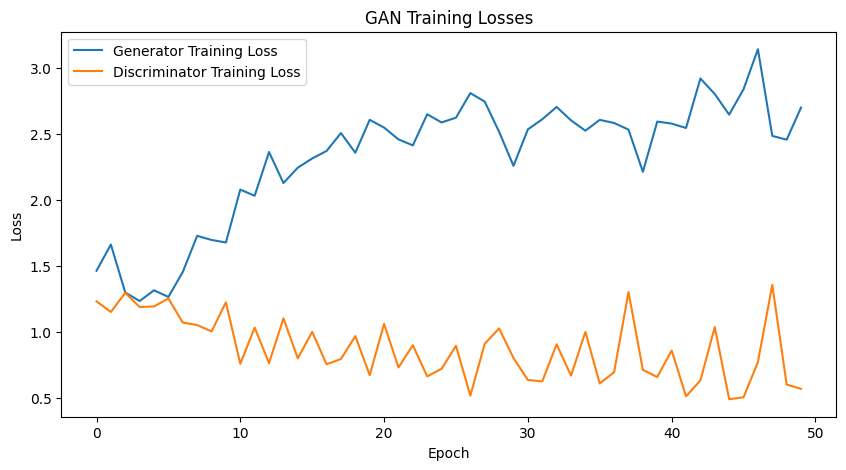

Best MSE: 0.0562
Best FID: 0.0001


In [14]:
# Plot losses and MSE score
plt.figure(figsize=(10, 5))
plt.plot(gen_train_losses, label='Generator Training Loss')
plt.plot(disc_train_losses, label='Discriminator Training Loss')
plt.title('GAN Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Best MSE: {best_mse:.4f}')
print(f'Best FID: {best_fid:.4f}')

In [15]:
def generate_image(input_image, gan_model):
    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)
    input_tensor = (input_tensor - 0.5) / 0.5

    with torch.no_grad():
        output_image = gan_model(input_tensor.to(device)).squeeze(0)

    output_image = (output_image.cpu().numpy().transpose(1, 2, 0) + 1) / 2.0
    output_image = (output_image * 255).astype('uint8')
    return output_image

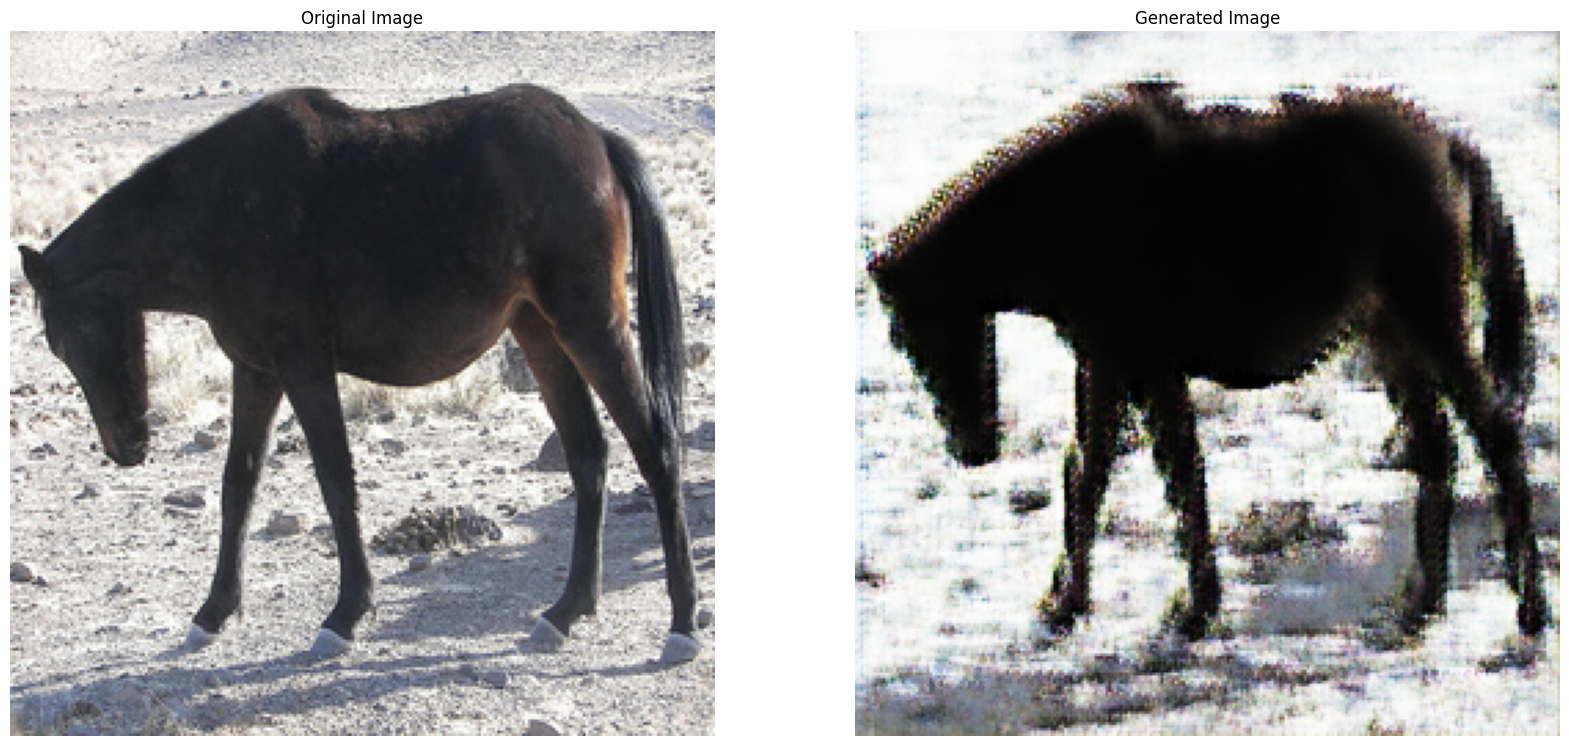

In [16]:
input_image_path = '/kaggle/input/image123/trainA/n02381460_1014.jpg'
input_image = Image.open(input_image_path).convert('RGB')
generated_image = generate_image(input_image, gan)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10))
ax1.imshow(input_image)
ax1.axis('off')
ax1.set_title('Original Image')
ax2.imshow(generated_image)
ax2.axis('off')
ax2.set_title('Generated Image')
plt.show()